In [1]:
## Imports
%matplotlib inline
import re
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.stats import multivariate_normal
from itertools import combinations
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib as mpl
from IPython.display import Markdown, display_html
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
import mpmath as mp
import warnings
## Below is to run more than 2 chains (CPU count)
import multiprocessing#; multiprocessing.cpu_count()
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
mp.dps = 50
import arviz as az
az.style.use("arviz-darkgrid")

from pymc3 import get_data,plot_forest,traceplot,plot_posterior,Model,sample,Normal,HalfCauchy,Uniform,Deterministic

In [2]:
## Import data
df = pd.read_csv('data.csv')
## Keep only median income for response
df = df.iloc[:, :-4]
## Drop all education variables except
## college degree or higher indicator
df = df.drop(df.iloc[:,16:24], axis=1)
## Clean subdivision column names
df['Subdivision'] =  [re.sub(r'\sCCD.*','', str(x)) for x in df['Subdivision']]
## Clean tract column names
df['Tract'] =  [re.sub(r'\,.*','', str(x)).split(' ',1)[1] for x in df['Tract']]
## Rename columns
df = df.rename({'Tract':'tract',
                'Subdivision':'sub',
                'Agriculture, forestry, fishing and hunting, and mining':'agri',
                'Construction':'constr',
                'Manufacturing':'manuf',
                'Wholesale trade':'wholetrade',
                'Retail trade':'retrade',
                'Transportation and warehousing, and utilities':'twu',
                'Information':'info',
                'Finance and insurance, and real estate and rental and leasing':'fire',
                'Professional, scientific, and management, and administrative and waste management services':'psmaw',
                'Educational services, and health care and social assistance':'eduhc',
                'Arts, entertainment, and recreation, and accommodation and food services':'artsrec',
                'Other services, except public administration':'other',
                'Public administration':'pubadmin',
                "Bachelor's degree or higher":"degree",
                'Median household income (dollars)':'income'}, axis=1)
## Convert column types to appropriate data type
for x in df.columns[3:]:
    df[x] = pd.to_numeric(df[x], errors='coerce')

In [3]:
## Get rid of tracts with missing values
## should be 14, so 505 left
## If not removed, get ImputationWarning about missing values
## Data in y_like contains missing values and will be automatically imputed from the sampling distribution
## and the following warning:
## [unnamed] ~ Normal has no finite default value to use, checked: ('median', 'mean', 'mode').
## Pass testval argument or adjust so value is finite.
## Talk to Teague to get more info on this
df = df[~df.isnull().any(axis=1)]

Skewness: 1.633989528720028


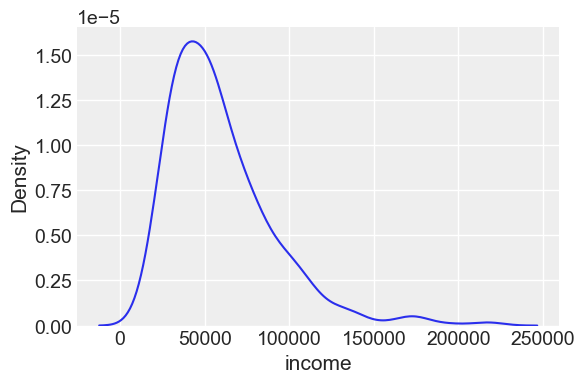

In [4]:
## See if income distribution
## is extremely skewed
## If so, perform log transformation

# · If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
# · If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
# · If the skewness is less than -1 or greater than 1, the data are highly skewed

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    sns.displot(df, x='income', kind='kde', height=4, aspect=1.5);
    
    print('Skewness:', df['income'].skew())

Skewness: 0.11512672668406079


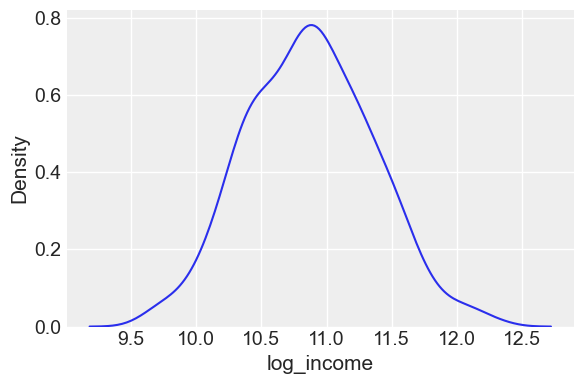

In [5]:
## If we don't log transform, trace
## function returns the following error
## ValueError “Mass matrix contains zeros on the diagonal. Some derivatives might always be zero.”

df['log_income'] = loginc = np.log(df.income).values

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    sns.displot(df, x='log_income', kind='kde', height=4, aspect=1.5);
    
    print('Skewness:', df['log_income'].skew())

In [6]:
## Lookup table (dict) for each unique subdivision, for indexing
divs = df['sub'].unique()
divisions = len(divs)
sub_lookup = dict(zip(divs, range(divisions)))

In [7]:
## Local copies of variables
sub = df['sub_code'] = df['sub'].replace(sub_lookup).values
income = df.income.values
agri = df.agri.values
constr = df.constr.values
manuf = df.manuf.values
wholetrade = df.wholetrade.values
retrade = df.retrade.values
twu = df.twu.values
info = df['info'].values
fire = df.fire.values
psmaw = df.psmaw.values
eduhc = df.eduhc.values
artsrec = df.artsrec.values
other = df.other.values
pubadmin = df.pubadmin.values
degree = df.degree.values

In [8]:
with Model() as miami_mod:
    # Priors for the fixed effects
    # a - overall intercept, income at mean levels
    mu_a = Normal('mu_a', mu=0., sd=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)
    
    #b - overall effect of argi jobs held
    mu_b = Normal('mu_b', mu=0., sd=1e5)
    sigma_b = HalfCauchy('sigma_b', 5)
    
    #c - overall effect of constr jobs held
    mu_c = Normal('mu_c', mu=0., sd=1e5)
    sigma_c = HalfCauchy('sigma_c', 5)
    
    #d - overall effect of manuf jobs held
    mu_d = Normal('mu_d', mu=0., sd=1e5)
    sigma_d = HalfCauchy('sigma_d', 5)
    
    #e - overall effect of wholetrade jobs held
    mu_e = Normal('mu_e', mu=0., sd=1e5)
    sigma_e = HalfCauchy('sigma_e', 5)

    #f - overall effect of retrade jobs held
    mu_f = Normal('mu_f', mu=0., sd=1e5)
    sigma_f = HalfCauchy('sigma_f', 5)
 
    #g - overall effect of twu jobs held
    mu_g = Normal('mu_g', mu=0., sd=1e5)
    sigma_g = HalfCauchy('sigma_g', 5)

    #h - overall effect of info jobs held
    mu_h = Normal('mu_h', mu=0., sd=1e5)
    sigma_h = HalfCauchy('sigma_h', 5)

    #i - overall effect of fire jobs held
    mu_i = Normal('mu_i', mu=0., sd=1e5)
    sigma_i = HalfCauchy('sigma_i', 5)

    #j - overall effect of psmaw jobs held
    mu_j = Normal('mu_j', mu=0., sd=1e5)
    sigma_j = HalfCauchy('sigma_j', 5)

    #k - overall effect of eduhc jobs held
    mu_k = Normal('mu_k', mu=0., sd=1e5)
    sigma_k = HalfCauchy('sigma_k', 5)

    #l - overall effect of artsrec jobs held
    mu_l = Normal('mu_l', mu=0., sd=1e5)
    sigma_l = HalfCauchy('sigma_l', 5)
  
    #m - overall effect of other jobs held
#     mu_m = Normal('mu_m', mu=0., sd=1e5)
#     sigma_m = HalfCauchy('sigma_m', 5)
    
    #n - overall effect of pubadmin jobs held
    mu_n = Normal('mu_n', mu=0., sd=1e5)
    sigma_n = HalfCauchy('sigma_n', 5)
 
    #o - overall effect of degrees held
    mu_o = Normal('mu_o', mu=0., sd=1e5)
    sigma_o = HalfCauchy('sigma_o', 5)
    
    # Random intercepts as offsets
    a_offset = Normal('a_offset', mu=0, sd=1, shape=divisions)
    a = Deterministic("a", mu_a + a_offset * sigma_a)
    
    # County level effect of agri jobs held as offset
    b_offset = Normal('b_offset', mu=0, sd=1, shape=divisions)
    b = Deterministic("b", mu_b + b_offset * sigma_b)
    
    # County level effect of constr jobs held as offset
    c_offset = Normal('c_offset', mu=0, sd=1, shape=divisions)
    c = Deterministic("c", mu_c + c_offset * sigma_c)
        
    # County level effect of manuf jobs held as offset
    d_offset = Normal('d_offset', mu=0, sd=1, shape=divisions)
    d = Deterministic("d", mu_d + d_offset * sigma_d)
    
    # County level effect of wholetrade jobs held as offset
    e_offset = Normal('e_offset', mu=0, sd=1, shape=divisions)
    e = Deterministic("e", mu_e + e_offset * sigma_e)
    
    # County level effect of retrade jobs held as offset
    f_offset = Normal('f_offset', mu=0, sd=1, shape=divisions)
    f = Deterministic("f", mu_f + f_offset * sigma_f)
    
    # County level effect of twu jobs held as offset
    g_offset = Normal('g_offset', mu=0, sd=1, shape=divisions)
    g = Deterministic("g", mu_g + g_offset * sigma_g)
    
    # County level effect of info jobs held as offset
    h_offset = Normal('h_offset', mu=0, sd=1, shape=divisions)
    h = Deterministic("h", mu_h + h_offset * sigma_h)
    
    # County level effect of fire jobs held as offset
    i_offset = Normal('i_offset', mu=0, sd=1, shape=divisions)
    i = Deterministic("i", mu_i + i_offset * sigma_i)
    
    # County level effect of psmaw jobs held as offset
    j_offset = Normal('j_offset', mu=0, sd=1, shape=divisions)
    j = Deterministic("j", mu_j + j_offset * sigma_j)
    
    # County level effect of eduhc jobs held as offset
    k_offset = Normal('k_offset', mu=0, sd=1, shape=divisions)
    k = Deterministic("k", mu_k + k_offset * sigma_k)
    
    # County level effect of artsrec jobs held as offset
    l_offset = Normal('l_offset', mu=0, sd=1, shape=divisions)
    l = Deterministic("l", mu_l + l_offset * sigma_l)
    
    # County level effect of other jobs held as offset
#     m_offset = Normal('m_offset', mu=0, sd=1, shape=divisions)
#     m = Deterministic("m", mu_m + m_offset * sigma_m)
    
    # County level effect of pubadmin jobs held as offset
    n_offset = Normal('n_offset', mu=0, sd=1, shape=divisions)
    n = Deterministic("n", mu_n + n_offset * sigma_n)
     
    # County level effect of degrees held as offset
    o_offset = Normal('o_offset', mu=0, sd=1, shape=divisions)
    o = Deterministic("o", mu_o + o_offset * sigma_o)
    
    # Residual Error
    sigma_y = HalfCauchy('sigma_y', 5)

    # Specification for the regression equation
    y_hat = a[sub] + b[sub]*agri + c[sub]*constr + d[sub]*manuf + e[sub]*wholetrade + f[sub]*retrade + g[sub]*twu + \
            h[sub]*info + i[sub]*fire + j[sub]*psmaw + k[sub]*eduhc + l[sub]*artsrec + n[sub]*pubadmin + o[sub]*degree

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=loginc)

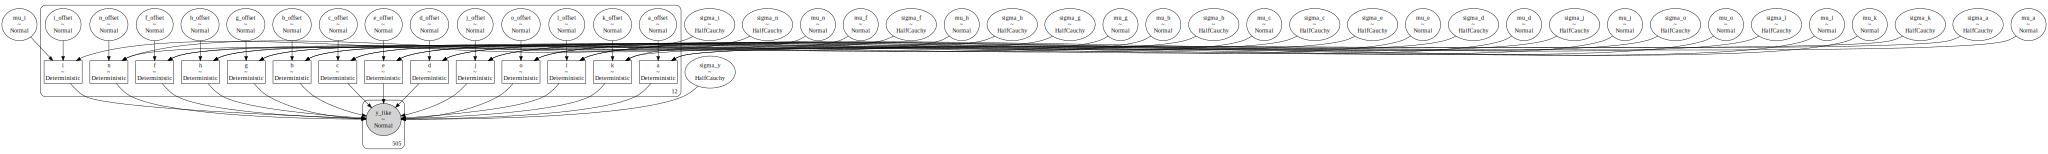

In [9]:
display(pm.model_to_graphviz(miami_mod))

In [10]:
## Set random_seed so results for project are reproducible
with miami_mod:
    miami_trace = sample(1000, n_init=50000, tune=1000, return_inferencedata=False, target_accept=0.9, random_seed=242)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, o_offset, n_offset, l_offset, k_offset, j_offset, i_offset, h_offset, g_offset, f_offset, e_offset, d_offset, c_offset, b_offset, a_offset, sigma_o, mu_o, sigma_n, mu_n, sigma_l, mu_l, sigma_k, mu_k, sigma_j, mu_j, sigma_i, mu_i, sigma_h, mu_h, sigma_g, mu_g, sigma_f, mu_f, sigma_e, mu_e, sigma_d, mu_d, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 543 seconds.


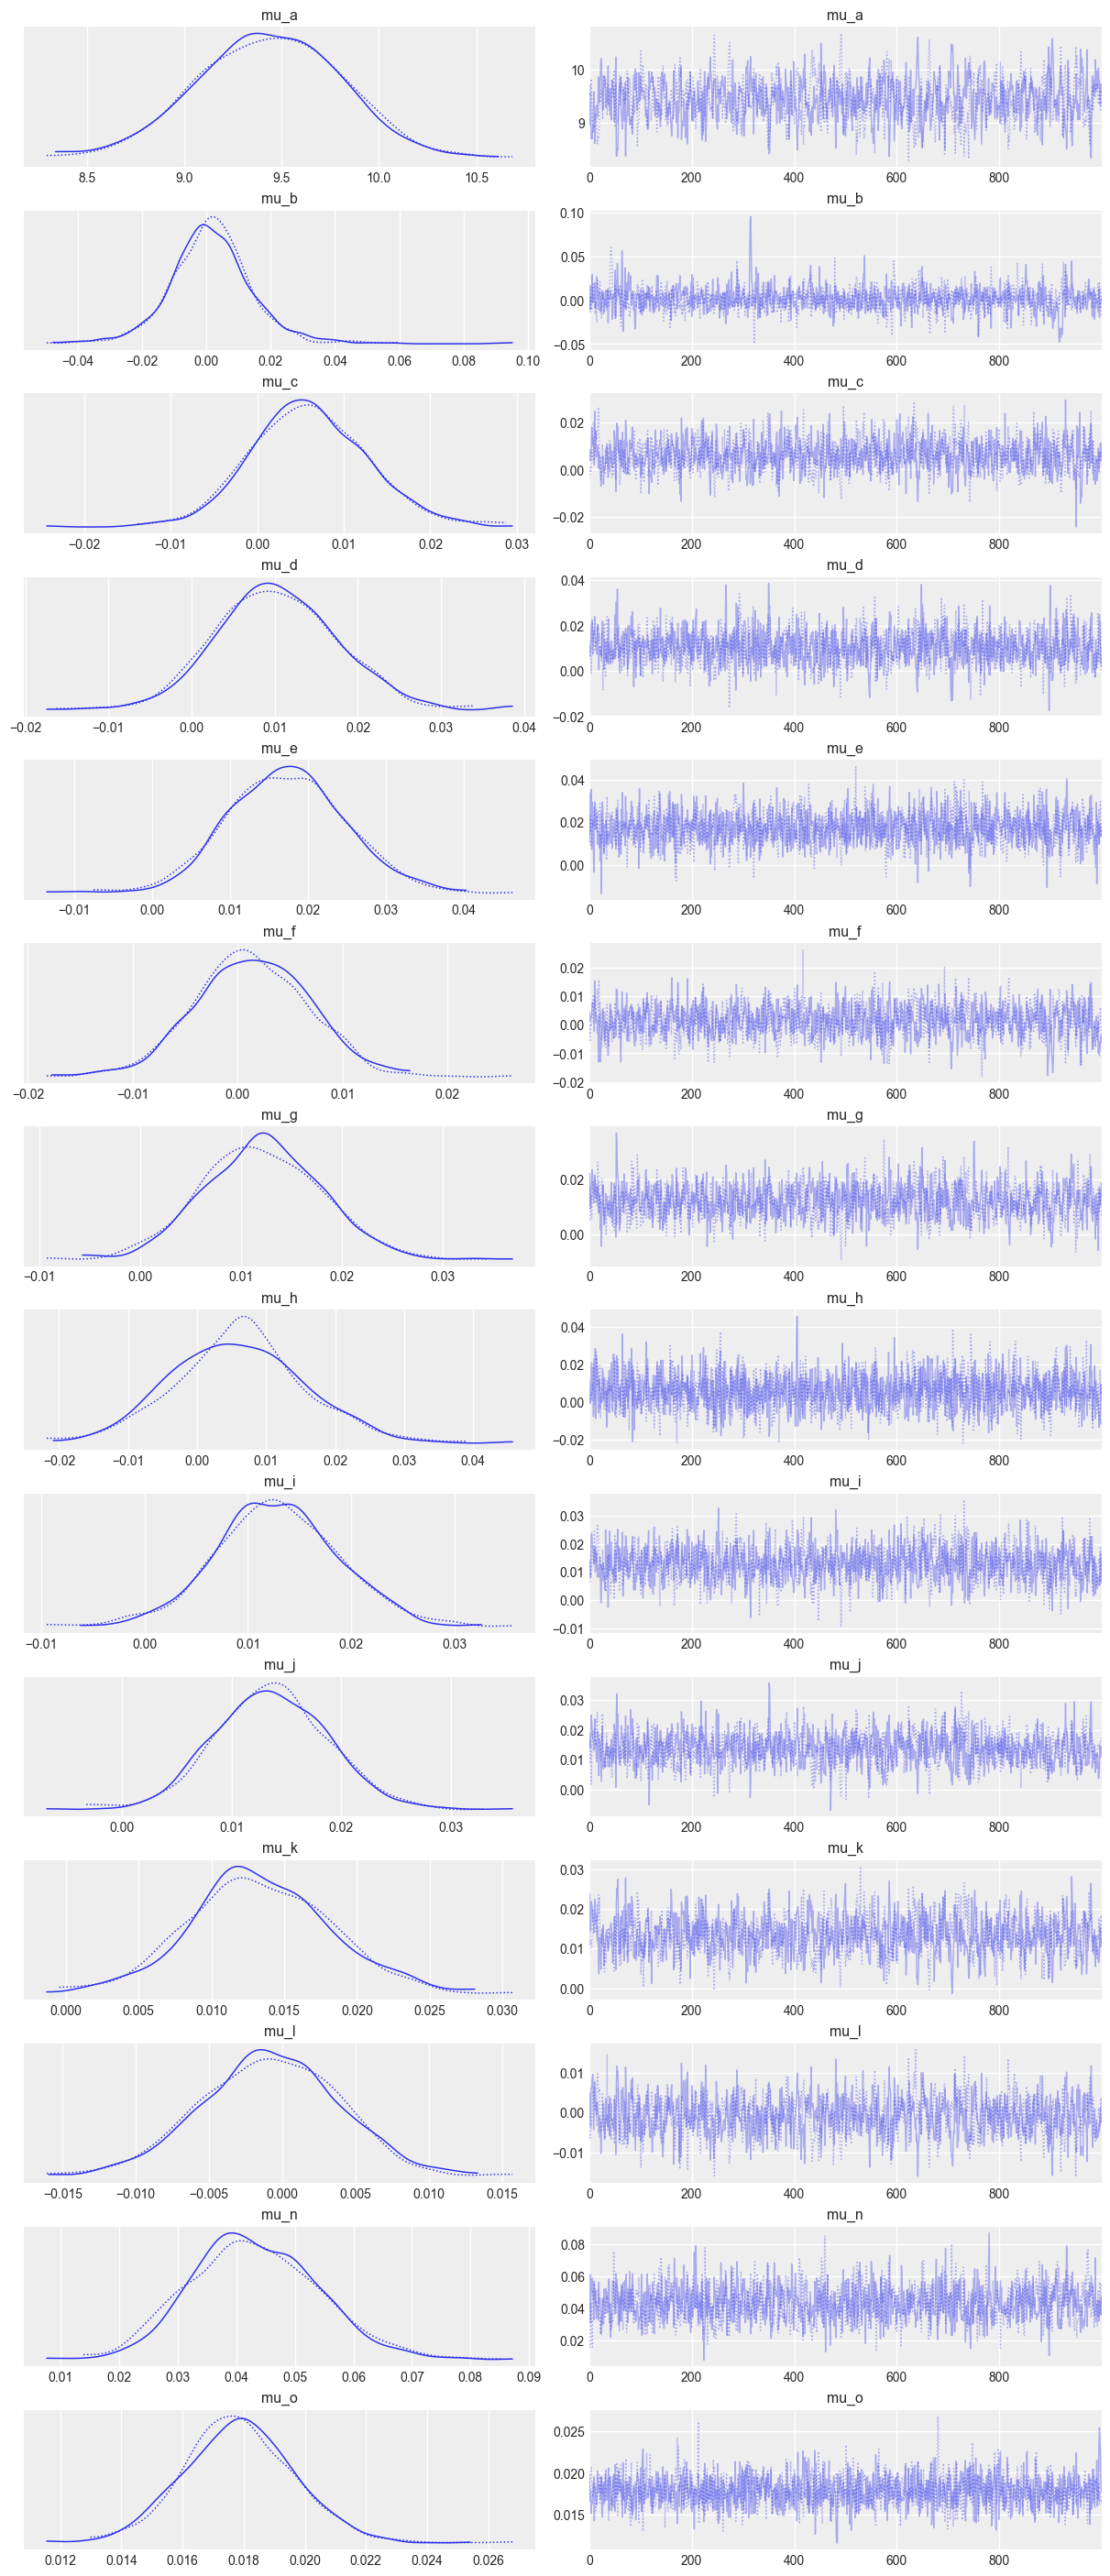

In [11]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    
    pm.plot_trace(miami_trace, var_names=['mu_a', 'mu_b', 'mu_c', 'mu_d', 'mu_e', 'mu_f', 'mu_g', 'mu_h', 
                                                  'mu_i', 'mu_j', 'mu_k', 'mu_l', 'mu_n', 'mu_o'])

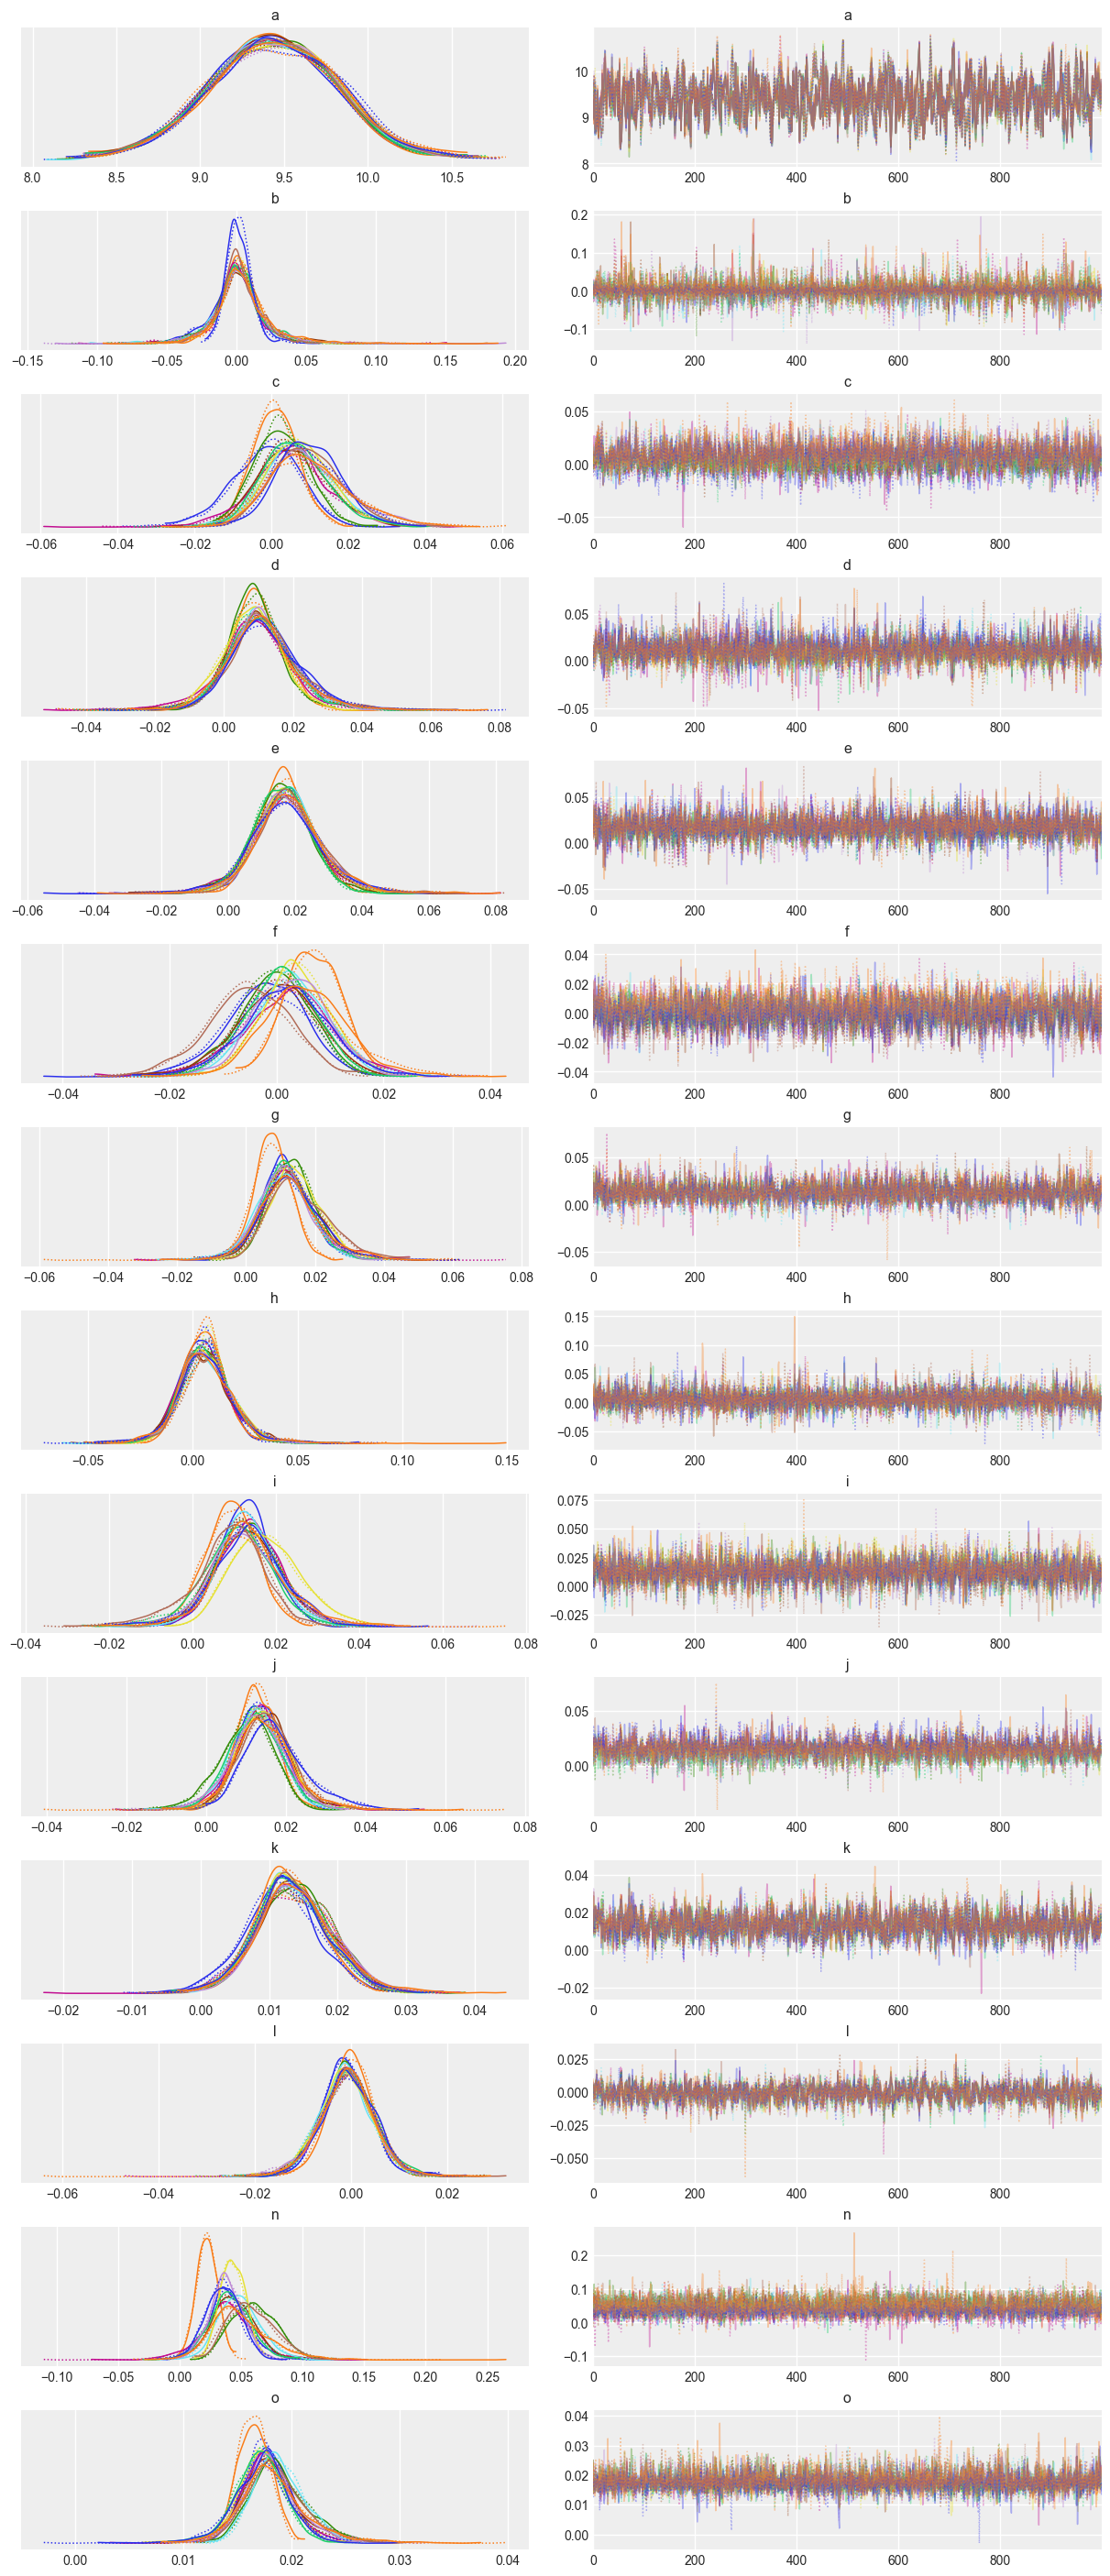

In [12]:
mpl.rc_file_defaults
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    
    pm.plot_trace(miami_trace, var_names=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'n', 'o'])

In [13]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    
    summ = pm.summary(miami_trace)

In [14]:
display(summ.sort_values(by='r_hat', ascending=False))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
g_offset[5]  -0.188  0.953  -1.857    1.655      0.015    0.023    3977.0   
e_offset[10] -0.006  1.031  -2.114    1.719      0.014    0.031    5736.0   
i_offset[2]   0.116  0.878  -1.486    1.745      0.015    0.023    3439.0   
f[1]          0.007  0.005  -0.003    0.016      0.000    0.000     814.0   
b[9]          0.001  0.016  -0.030    0.033      0.000    0.000    1784.0   
...             ...    ...     ...      ...        ...      ...       ...   
j_offset[0]  -0.024  0.850  -1.543    1.663      0.018    0.020    2325.0   
i_offset[11]  0.125  1.019  -1.664    2.151      0.016    0.026    4122.0   
i_offset[10]  0.054  1.009  -1.960    1.845      0.014    0.027    4980.0   
i_offset[9]  -0.526  0.962  -2.459    1.141      0.022    0.021    1985.0   
sigma_y       0.242  0.008   0.228    0.257      0.000    0.000    2520.0   

              ess_tail  r_hat  
g_offset[5]     1456.0   1.01  
e_offset[10]    1145.0   1.01  
i_offset[2]     1148.0   1.01  
f[1]            1460.0   1.01  
b[9]            1578.0   1.01  
...                ...    ...  
j_offset[0]     1305.0   1.00  
i_offset[11]    1430.0   1.00  
i_offset[10]    1317.0   1.00  
i_offset[9]     1238.0   1.00  
sigma_y         1585.0   1.00  

[365 rows x 9 columns]

In [15]:
display(summ.iloc[340:352, :])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
n[0]   0.039  0.018   0.006    0.074      0.000      0.0    2225.0    1852.0   
n[1]   0.022  0.009   0.006    0.038      0.000      0.0    1064.0    1382.0   
n[2]   0.061  0.018   0.025    0.090      0.001      0.0    1126.0    1144.0   
n[3]   0.039  0.023  -0.007    0.081      0.000      0.0    2541.0    1606.0   
n[4]   0.043  0.018   0.010    0.077      0.000      0.0    2181.0    1851.0   
n[5]   0.048  0.018   0.014    0.082      0.000      0.0    1796.0    1269.0   
n[6]   0.043  0.010   0.024    0.061      0.000      0.0    1518.0    1496.0   
n[7]   0.041  0.018   0.007    0.073      0.000      0.0    2313.0    1581.0   
n[8]   0.038  0.014   0.012    0.064      0.000      0.0    2252.0    1828.0   
n[9]   0.058  0.019   0.024    0.093      0.001      0.0    1077.0    1508.0   
n[10]  0.035  0.014   0.008    0.061      0.000      0.0    1883.0    1663.0   
n[11]  0.050  0.026   0.004    0.097      0.001      0.0    1756.0    1535.0   

       r_hat  
n[0]     1.0  
n[1]     1.0  
n[2]     1.0  
n[3]     1.0  
n[4]     1.0  
n[5]     1.0  
n[6]     1.0  
n[7]     1.0  
n[8]     1.0  
n[9]     1.0  
n[10]    1.0  
n[11]    1.0

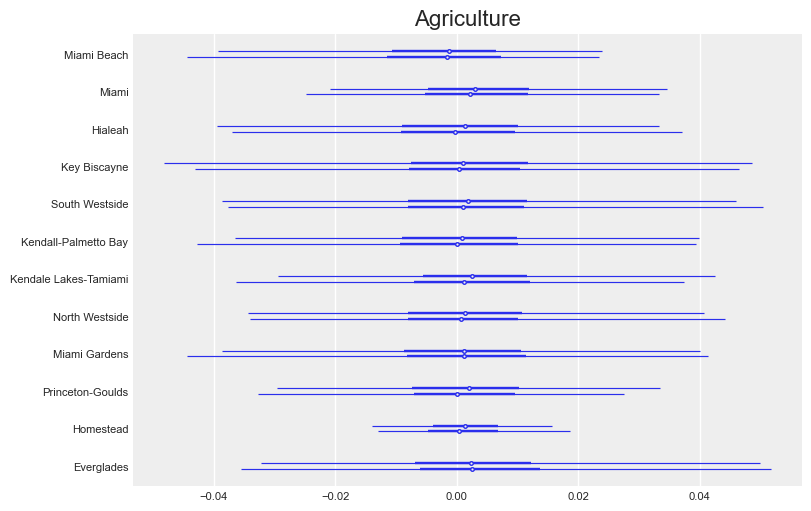

In [16]:
subdivs = ('Miami Beach','Miami','Hialeah','Key Biscayne','South Westside','Kendall-Palmetto Bay','Kendale Lakes-Tamiami',
    'North Westside','Miami Gardens','Princeton-Goulds','Homestead','Everglades')
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    ax = az.plot_forest(miami_trace, var_names=["b"], figsize=(8, 5), r_hat=False, combined=False, textsize=8)
    ax[0].set_yticklabels(subdivs[::-1])
    ax[0].set_title("Agriculture");

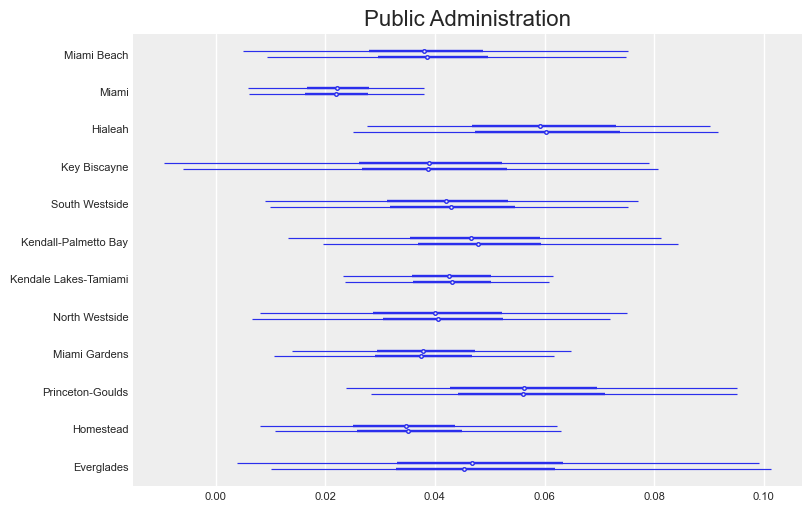

In [17]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    ax = az.plot_forest(miami_trace, var_names="n", figsize=(8, 5), r_hat=False, combined=False, textsize=8)
    ax[0].set_yticklabels(subdivs[::-1])
    ax[0].set_title("Public Administration");

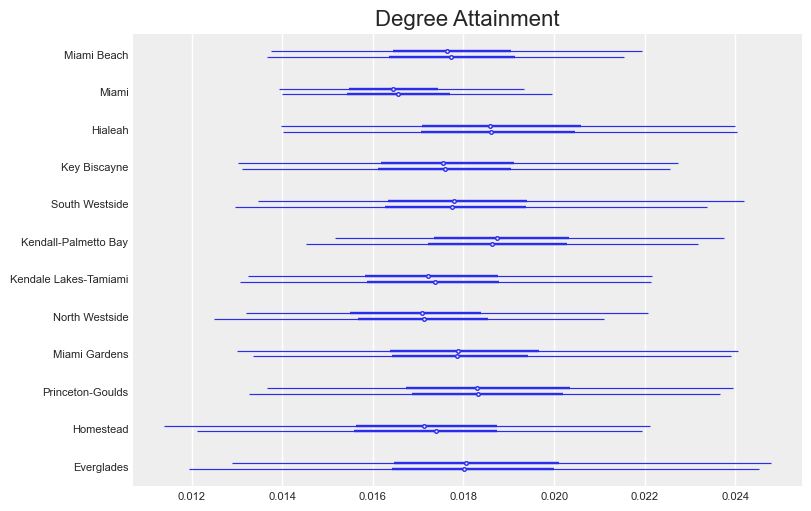

In [18]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    ax = az.plot_forest(miami_trace, var_names="o", figsize=(8, 5), r_hat=False, combined=False, textsize=8)
    ax[0].set_yticklabels(subdivs[::-1])
    ax[0].set_title("Degree Attainment");

In [19]:
subdivs = ('Miami Beach','Miami','Hialeah','Key Biscayne','South Westside','Kendall-Palmetto Bay','Kendale Lakes-Tamiami',
    'North Westside','Miami Gardens','Princeton-Goulds','Homestead','Everglades')
var = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'n', 'o']
effects = pd.DataFrame({'subdivision':subdivs})
for x in var:
    effects[x] = miami_trace[x].mean(axis=0)
effects = effects.rename({'a':'intercept',
                'b':'agri',
                'c':'constr',
                'd':'manuf',
                'e':'wholetrade',
                'f':'retrade',
                'g':'twu',
                'h':'info',
                'i':'fire',
                'j':'psmaw',
                'k':'eduhc',
                'l':'artsrec',
                'n':'pubadmin',
                "o":"degree"}, axis=1)
display(effects)

subdivision  intercept      agri    constr     manuf  \
0             Miami Beach   9.402577 -0.003335 -0.001498  0.011925   
1                   Miami   9.411131  0.003417  0.000668  0.008964   
2                 Hialeah   9.424580  0.000322  0.002255  0.008786   
3            Key Biscayne   9.435829  0.002179  0.004982  0.008196   
4          South Westside   9.441497  0.002901  0.006035  0.010185   
5    Kendall-Palmetto Bay   9.437154  0.000109  0.007172  0.010405   
6   Kendale Lakes-Tamiami   9.452554  0.003065  0.007094  0.007667   
7          North Westside   9.428118  0.001645  0.006179  0.010318   
8           Miami Gardens   9.447679  0.001824  0.009957  0.011321   
9        Princeton-Goulds   9.444844  0.000979  0.009460  0.012526   
10              Homestead   9.461528  0.001181  0.009593  0.012402   
11             Everglades   9.467834  0.004716  0.010137  0.010780   

    wholetrade   retrade       twu      info      fire     psmaw     eduhc  \
0     0.018055 -0.002248  0.011251  0.004304  0.012876  0.013349  0.011620   
1     0.017040  0.006726  0.007682  0.005375  0.009313  0.012590  0.012668   
2     0.015910 -0.000291  0.013338  0.005222  0.013690  0.009967  0.014157   
3     0.016941  0.001581  0.012251  0.005106  0.014093  0.013420  0.013578   
4     0.015988 -0.000143  0.012881  0.006280  0.013029  0.014893  0.013802   
5     0.018147  0.002831  0.010605  0.006488  0.013022  0.012217  0.013352   
6     0.017702  0.003737  0.014222  0.006913  0.017918  0.014385  0.013209   
7     0.015536  0.000636  0.011577  0.005709  0.010960  0.012285  0.013167   
8     0.017618  0.002415  0.011314  0.006377  0.012922  0.012722  0.014125   
9     0.019042 -0.005465  0.015547  0.007427  0.008508  0.015462  0.013212   
10    0.017080  0.001583  0.012927  0.006053  0.013360  0.017723  0.013058   
11    0.018417  0.005424  0.012567  0.006646  0.013840  0.014888  0.014074   

     artsrec  pubadmin    degree  
0  -0.001097  0.039216  0.017782  
1   0.000054  0.022164  0.016508  
2  -0.001129  0.060682  0.018949  
3  -0.001025  0.039126  0.017630  
4  -0.000967  0.043175  0.017922  
5  -0.001327  0.048025  0.018885  
6  -0.001440  0.043247  0.017328  
7  -0.000574  0.040646  0.017028  
8  -0.001149  0.037985  0.018120  
9  -0.000667  0.057986  0.018621  
10 -0.000390  0.034918  0.017135  
11 -0.000763  0.049554  0.018476

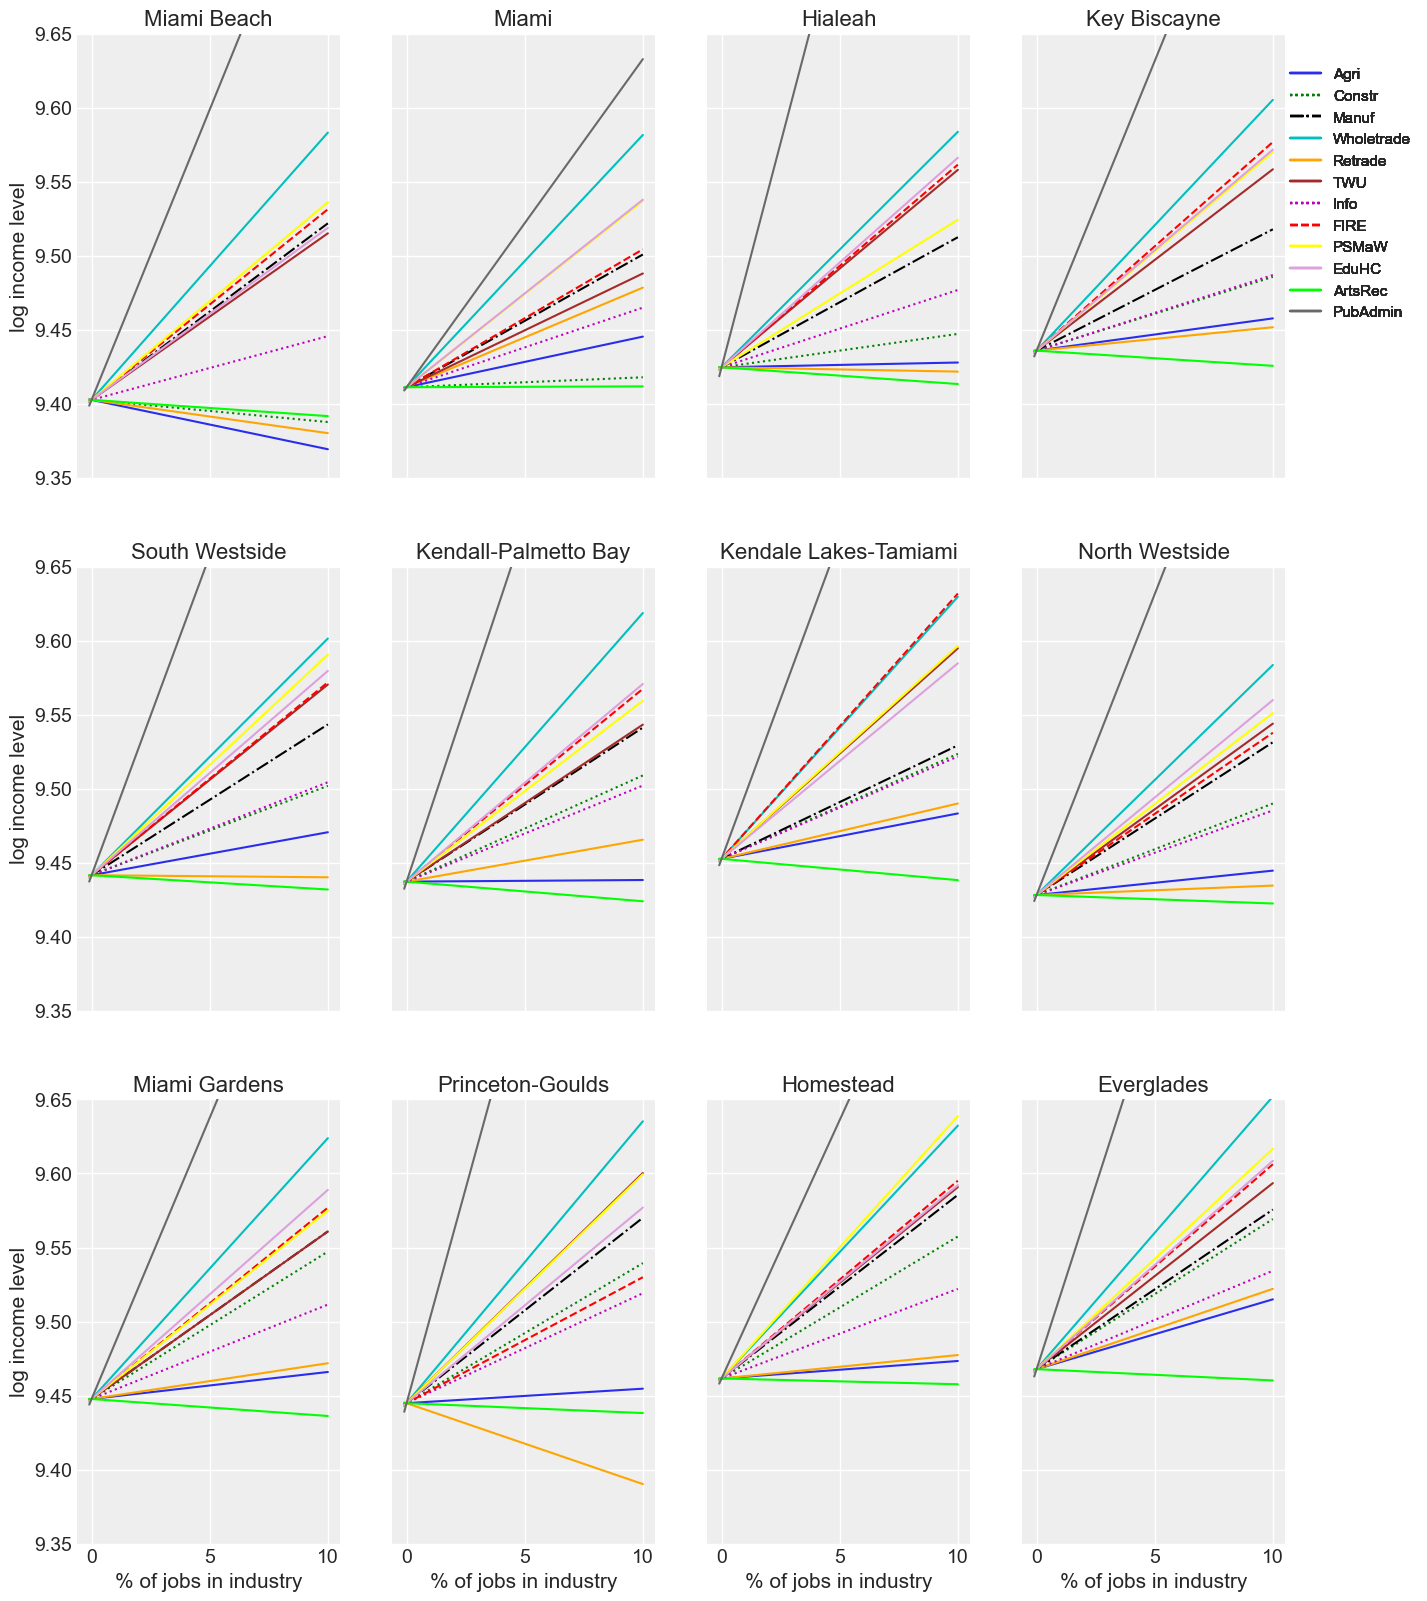

In [20]:
subdivs = ('Miami Beach','Miami','Hialeah','Key Biscayne','South Westside','Kendall-Palmetto Bay','Kendale Lakes-Tamiami',
    'North Westside','Miami Gardens','Princeton-Goulds','Homestead','Everglades')
fig, axes = plt.subplots(3, 4, figsize=(15, 20), sharey=True, sharex=True, constrained_layout=False)
axes = axes.ravel()

for i,s in enumerate(subdivs):
    
    y = df.log_income[df['sub']==s]
    xvals = np.linspace(-0.1, 10)
    intercept = miami_trace['a'].mean(axis=0)
    agri = miami_trace['b'].mean(axis=0)
    constr = miami_trace['c'].mean(axis=0)
    manuf = miami_trace['d'].mean(axis=0)
    wholetrade = miami_trace['e'].mean(axis=0)
    retrade = miami_trace['f'].mean(axis=0)
    twu = miami_trace['g'].mean(axis=0)
    info = miami_trace['h'].mean(axis=0)
    fire = miami_trace['i'].mean(axis=0)
    psmaw = miami_trace['j'].mean(axis=0)
    eduhc = miami_trace['k'].mean(axis=0)
    artsrec = miami_trace['l'].mean(axis=0)
    pubadmin = miami_trace['n'].mean(axis=0)
    
    # Partial pooling esimate
    axes[i].plot(xvals, agri[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], label='Agri')
    axes[i].plot(xvals, constr[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'g:', label='Constr')
    axes[i].plot(xvals, manuf[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'k-.', label='Manuf')
    axes[i].plot(xvals, wholetrade[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'c', label='Wholetrade')
    axes[i].plot(xvals, retrade[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'orange', label='Retrade')
    axes[i].plot(xvals, twu[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'brown', label='TWU')
    axes[i].plot(xvals, info[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'm:',label='Info')
    axes[i].plot(xvals, fire[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'r--', label='FIRE')
    axes[i].plot(xvals, psmaw[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'yellow', label='PSMaW')
    axes[i].plot(xvals, eduhc[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'plum', label='EduHC')
    axes[i].plot(xvals, artsrec[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'lime', label='ArtsRec')
    axes[i].plot(xvals, pubadmin[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'dimgrey', label='PubAdmin')
    axes[i].set_title(s)
    axes[i].set_ylim(9.35, 9.65)
    handles, labels = axes[i].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=11, loc='center right', bbox_to_anchor=(1.01,0.8), borderaxespad=-0.8)
    plt.subplots_adjust(right=0.93)
    if not i%4:
        axes[i].set_ylabel('log income level')
    if i in [8,9,10,11]:
        axes[i].set_xlabel('% of jobs in industry')

In [29]:
# fig, axes = plt.subplots(3, 4, figsize=(15, 10), sharey=True, sharex=True, constrained_layout=False)
# axes = axes.ravel()

# for i,s in enumerate(subdivs):
    
#     y = df.log_income[df['sub']==s]
#     x = df.degree[df['sub']==s]
#     xvals = np.linspace(-0.1, 100)
#     intercept = miami_trace['a'].mean(axis=0)
#     degree = miami_trace['o'].mean(axis=0)
#     axes[i].scatter(x, y, alpha=0.4)
    
#     # Partial pooling esimate
#     axes[i].plot(xvals, degree[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'r', label='Degree')
#     axes[i].set_title(s)
#     #axes[i].set_ylim(9.35, 9.65)
#     handles, labels = axes[i].get_legend_handles_labels()
#     fig.legend(handles, labels, fontsize=11, loc='center right', bbox_to_anchor=(1.01,0.8), borderaxespad=-0.8)
#     plt.subplots_adjust(right=0.93)
#     if not i%4:
#         axes[i].set_ylabel('log income level')
#     if i in [8,9,10,11]:
#         axes[i].set_xlabel("% with Bachelor's")

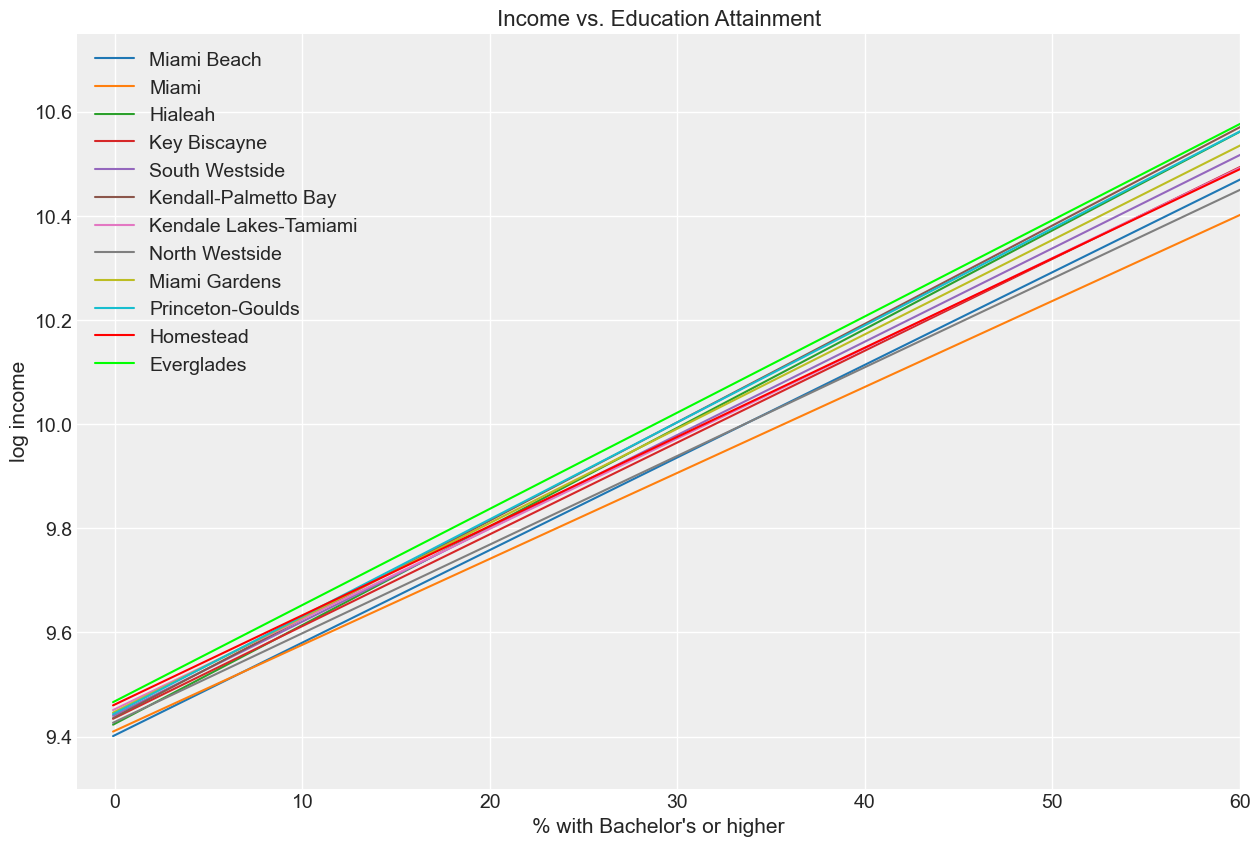

In [24]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
                                                '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'r', 'lime'])

fig, axes = plt.subplots(1, 1, figsize=(15, 10), sharey=True, sharex=True, constrained_layout=False)

for i,s in enumerate(subdivs):
    
    y = df.log_income[df['sub']==s]
    x = df.degree[df['sub']==s]
    xvals = np.linspace(-0.1, 100)
    intercept = miami_trace['a'].mean(axis=0)
    degree = miami_trace['o'].mean(axis=0)
    # axes.scatter(x, y, alpha=0.4, label=s)
    axes.plot(xvals, degree[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], label=s)
    axes.set_xlim(-2, 60)
    axes.set_ylim(9.3, 10.75)
    axes.set_ylabel('log income')
    axes.set_xlabel("% with Bachelor's or higher")
    axes.set_title('Income vs. Education Attainment')
    axes.legend()

In [22]:
import plotly.express as px

plotter = pd.DataFrame({'Subdivision':np.repeat(subdivs,50)})
b = []
d = []
for i,s in enumerate(subdivs):

    intercept = miami_trace['a'].mean(axis=0)
    b.append(intercept[sub_lookup[s]])
    degree = miami_trace['o'].mean(axis=0)
    d.append(degree[sub_lookup[s]])
    
plotter['intercept'] = np.repeat(b,50)
plotter['degree'] = np.repeat(d,50)
plotter["% with Bachelor's"] = list(np.linspace(-0.1, 100))*12
plotter["log income"] = plotter['degree']*plotter["% with Bachelor's"] + plotter['intercept']

fig = px.line(plotter, x="% with Bachelor's", y="log income", color="Subdivision",hover_name="Subdivision")
fig.show()

## Supplementary/Extra Models Below

In [271]:
## Local copies of variables
sub = df['sub_code'] = df['sub'].replace(sub_lookup).values
income = df.income.values
agri = df.agri.values
constr = df.constr.values
manuf = df.manuf.values
wholetrade = df.wholetrade.values
retrade = df.retrade.values
twu = df.twu.values
info = df['info'].values
fire = df.fire.values
psmaw = df.psmaw.values
eduhc = df.eduhc.values
artsrec = df.artsrec.values
other = df.other.values
pubadmin = df.pubadmin.values
degree = df.degree.values

In [272]:
## No parameter for % with degree
with Model() as job_mod:
    # Priors for the fixed effects
    # a - overall intercept, income at mean levels
    mu_a = Normal('mu_a', mu=0., sd=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)
    
    #b - overall effect of argi jobs held
    mu_b = Normal('mu_b', mu=0., sd=1e5)
    sigma_b = HalfCauchy('sigma_b', 5)
    
    #c - overall effect of constr jobs held
    mu_c = Normal('mu_c', mu=0., sd=1e5)
    sigma_c = HalfCauchy('sigma_c', 5)
    
    #d - overall effect of manuf jobs held
    mu_d = Normal('mu_d', mu=0., sd=1e5)
    sigma_d = HalfCauchy('sigma_d', 5)
    
    #e - overall effect of wholetrade jobs held
    mu_e = Normal('mu_e', mu=0., sd=1e5)
    sigma_e = HalfCauchy('sigma_e', 5)

    #f - overall effect of retrade jobs held
    mu_f = Normal('mu_f', mu=0., sd=1e5)
    sigma_f = HalfCauchy('sigma_f', 5)
 
    #g - overall effect of twu jobs held
    mu_g = Normal('mu_g', mu=0., sd=1e5)
    sigma_g = HalfCauchy('sigma_g', 5)

    #h - overall effect of info jobs held
    mu_h = Normal('mu_h', mu=0., sd=1e5)
    sigma_h = HalfCauchy('sigma_h', 5)

    #i - overall effect of fire jobs held
    mu_i = Normal('mu_i', mu=0., sd=1e5)
    sigma_i = HalfCauchy('sigma_i', 5)

    #j - overall effect of psmaw jobs held
    mu_j = Normal('mu_j', mu=0., sd=1e5)
    sigma_j = HalfCauchy('sigma_j', 5)

    #k - overall effect of eduhc jobs held
    mu_k = Normal('mu_k', mu=0., sd=1e5)
    sigma_k = HalfCauchy('sigma_k', 5)

    #l - overall effect of artsrec jobs held
    mu_l = Normal('mu_l', mu=0., sd=1e5)
    sigma_l = HalfCauchy('sigma_l', 5)
    
    #n - overall effect of pubadmin jobs held
    mu_n = Normal('mu_n', mu=0., sd=1e5)
    sigma_n = HalfCauchy('sigma_n', 5)
    
    # Random intercepts as offsets
    a_offset = Normal('a_offset', mu=0, sd=1, shape=divisions)
    a = Deterministic("a", mu_a + a_offset * sigma_a)
    
    # County level effect of agri jobs held as offset
    b_offset = Normal('b_offset', mu=0, sd=1, shape=divisions)
    b = Deterministic("b", mu_b + b_offset * sigma_b)
    
    # County level effect of constr jobs held as offset
    c_offset = Normal('c_offset', mu=0, sd=1, shape=divisions)
    c = Deterministic("c", mu_c + c_offset * sigma_c)
        
    # County level effect of manuf jobs held as offset
    d_offset = Normal('d_offset', mu=0, sd=1, shape=divisions)
    d = Deterministic("d", mu_d + d_offset * sigma_d)
    
    # County level effect of wholetrade jobs held as offset
    e_offset = Normal('e_offset', mu=0, sd=1, shape=divisions)
    e = Deterministic("e", mu_e + e_offset * sigma_e)
    
    # County level effect of retrade jobs held as offset
    f_offset = Normal('f_offset', mu=0, sd=1, shape=divisions)
    f = Deterministic("f", mu_f + f_offset * sigma_f)
    
    # County level effect of twu jobs held as offset
    g_offset = Normal('g_offset', mu=0, sd=1, shape=divisions)
    g = Deterministic("g", mu_g + g_offset * sigma_g)
    
    # County level effect of info jobs held as offset
    h_offset = Normal('h_offset', mu=0, sd=1, shape=divisions)
    h = Deterministic("h", mu_h + h_offset * sigma_h)
    
    # County level effect of fire jobs held as offset
    i_offset = Normal('i_offset', mu=0, sd=1, shape=divisions)
    i = Deterministic("i", mu_i + i_offset * sigma_i)
    
    # County level effect of psmaw jobs held as offset
    j_offset = Normal('j_offset', mu=0, sd=1, shape=divisions)
    j = Deterministic("j", mu_j + j_offset * sigma_j)
    
    # County level effect of eduhc jobs held as offset
    k_offset = Normal('k_offset', mu=0, sd=1, shape=divisions)
    k = Deterministic("k", mu_k + k_offset * sigma_k)
    
    # County level effect of artsrec jobs held as offset
    l_offset = Normal('l_offset', mu=0, sd=1, shape=divisions)
    l = Deterministic("l", mu_l + l_offset * sigma_l)
    
    # County level effect of pubadmin jobs held as offset
    n_offset = Normal('n_offset', mu=0, sd=1, shape=divisions)
    n = Deterministic("n", mu_n + n_offset * sigma_n)
    
    # Residual Error
    sigma_y = HalfCauchy('sigma_y', 5)

    # Specification for the regression equation
    y_hat = a[sub] + b[sub]*agri + c[sub]*constr + d[sub]*manuf + e[sub]*wholetrade + f[sub]*retrade + g[sub]*twu + \
            h[sub]*info + i[sub]*fire + j[sub]*psmaw + k[sub]*eduhc + l[sub]*artsrec + n[sub]*pubadmin

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=loginc)

In [273]:
with job_mod:
    job_trace = sample(1000, n_init=50000, tune=1000, return_inferencedata=False, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, n_offset, l_offset, k_offset, j_offset, i_offset, h_offset, g_offset, f_offset, e_offset, d_offset, c_offset, b_offset, a_offset, sigma_n, mu_n, sigma_l, mu_l, sigma_k, mu_k, sigma_j, mu_j, sigma_i, mu_i, sigma_h, mu_h, sigma_g, mu_g, sigma_f, mu_f, sigma_e, mu_e, sigma_d, mu_d, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 436 seconds.
The number of effective samples is smaller than 25% for some parameters.


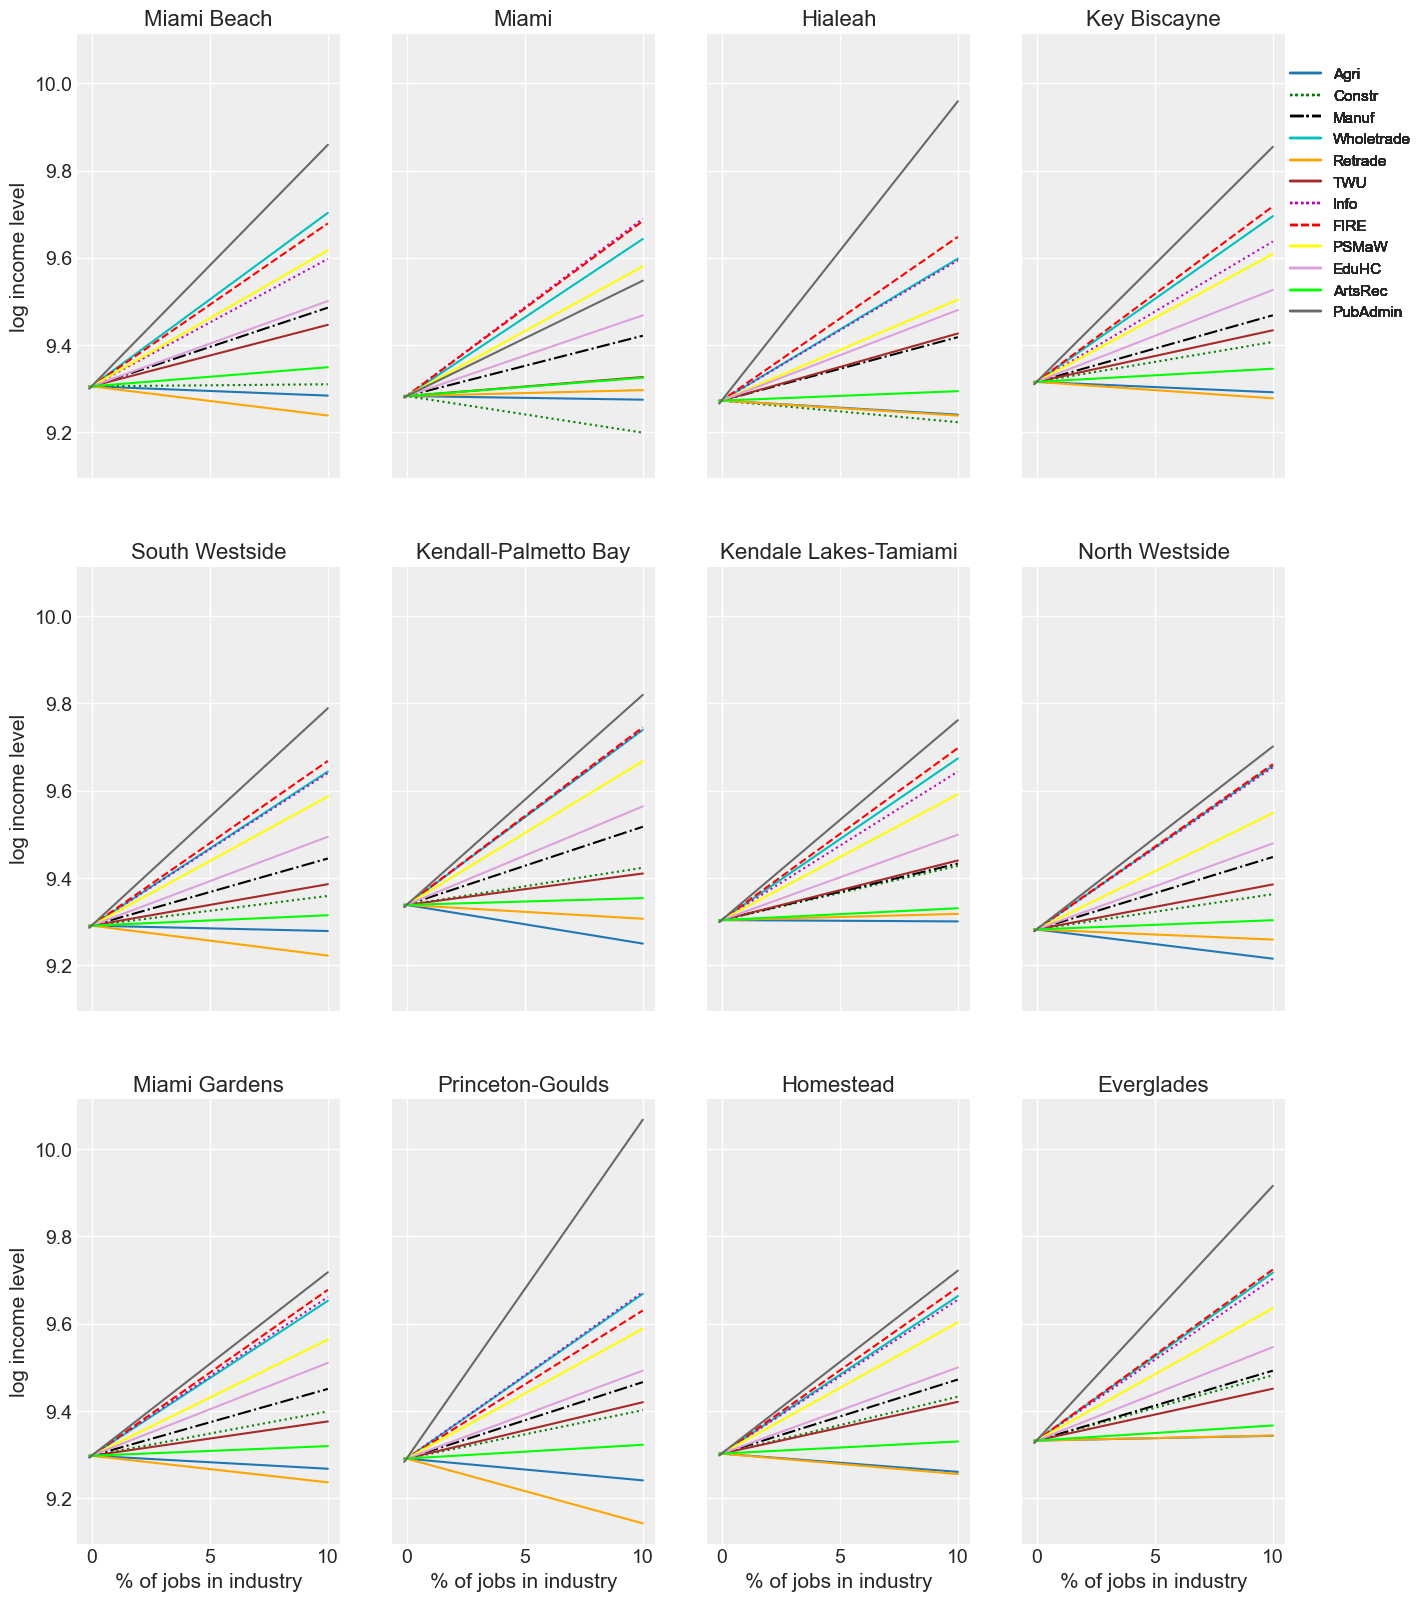

In [275]:
subdivs = ('Miami Beach','Miami','Hialeah','Key Biscayne','South Westside','Kendall-Palmetto Bay','Kendale Lakes-Tamiami',
    'North Westside','Miami Gardens','Princeton-Goulds','Homestead','Everglades')
fig, axes = plt.subplots(3, 4, figsize=(15, 20), sharey=True, sharex=True, constrained_layout=False)
axes = axes.ravel()

for i,s in enumerate(subdivs):
    
    y = df.log_income[df['sub']==s]
    xvals = np.linspace(-0.1, 10)
    intercept = job_trace['a'].mean(axis=0)
    agri = job_trace['b'].mean(axis=0)
    constr = job_trace['c'].mean(axis=0)
    manuf = job_trace['d'].mean(axis=0)
    wholetrade = job_trace['e'].mean(axis=0)
    retrade = job_trace['f'].mean(axis=0)
    twu = job_trace['g'].mean(axis=0)
    info = job_trace['h'].mean(axis=0)
    fire = job_trace['i'].mean(axis=0)
    psmaw = job_trace['j'].mean(axis=0)
    eduhc = job_trace['k'].mean(axis=0)
    artsrec = job_trace['l'].mean(axis=0)
    pubadmin = job_trace['n'].mean(axis=0)
    
    # Partial pooling esimate
    axes[i].plot(xvals, agri[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], label='Agri')
    axes[i].plot(xvals, constr[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'g:', label='Constr')
    axes[i].plot(xvals, manuf[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'k-.', label='Manuf')
    axes[i].plot(xvals, wholetrade[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'c', label='Wholetrade')
    axes[i].plot(xvals, retrade[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'orange', label='Retrade')
    axes[i].plot(xvals, twu[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'brown', label='TWU')
    axes[i].plot(xvals, info[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'm:',label='Info')
    axes[i].plot(xvals, fire[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'r--', label='FIRE')
    axes[i].plot(xvals, psmaw[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'yellow', label='PSMaW')
    axes[i].plot(xvals, eduhc[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'plum', label='EduHC')
    axes[i].plot(xvals, artsrec[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'lime', label='ArtsRec')
    axes[i].plot(xvals, pubadmin[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], 'dimgrey', label='PubAdmin')
    axes[i].set_title(s)
    #axes[i].set_ylim(9.35, 9.65)
    handles, labels = axes[i].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=11, loc='center right', bbox_to_anchor=(1.01,0.8), borderaxespad=-0.8)
    plt.subplots_adjust(right=0.93)
    if not i%4:
        axes[i].set_ylabel('log income level')
    if i in [8,9,10,11]:
        axes[i].set_xlabel('% of jobs in industry')

In [276]:
## Local copies of variables
degree = df.degree.values
## Only model effect of having degree
with Model() as deg_mod:
    # Priors for the fixed effects
    # a - overall intercept, income at mean levels
    mu_a = Normal('mu_a', mu=0., sd=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)
 
    #o - overall effect of degrees held
    mu_o = Normal('mu_o', mu=0., sd=1e5)
    sigma_o = HalfCauchy('sigma_o', 5)
    
    # Random intercepts as offsets
    a_offset = Normal('a_offset', mu=0, sd=1, shape=divisions)
    a = Deterministic("a", mu_a + a_offset * sigma_a)
     
    # County level effect of degrees held as offset
    o_offset = Normal('o_offset', mu=0, sd=1, shape=divisions)
    o = Deterministic("o", mu_o + o_offset * sigma_o)
    
    # Residual Error
    sigma_y = HalfCauchy('sigma_y', 5)

    # Specification for the regression equation
    y_hat = a[sub] + o[sub]*degree

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=loginc)

In [277]:
with deg_mod:
    deg_trace = sample(1000, n_init=50000, tune=1000, return_inferencedata=False, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, o_offset, a_offset, sigma_o, mu_o, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 102 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


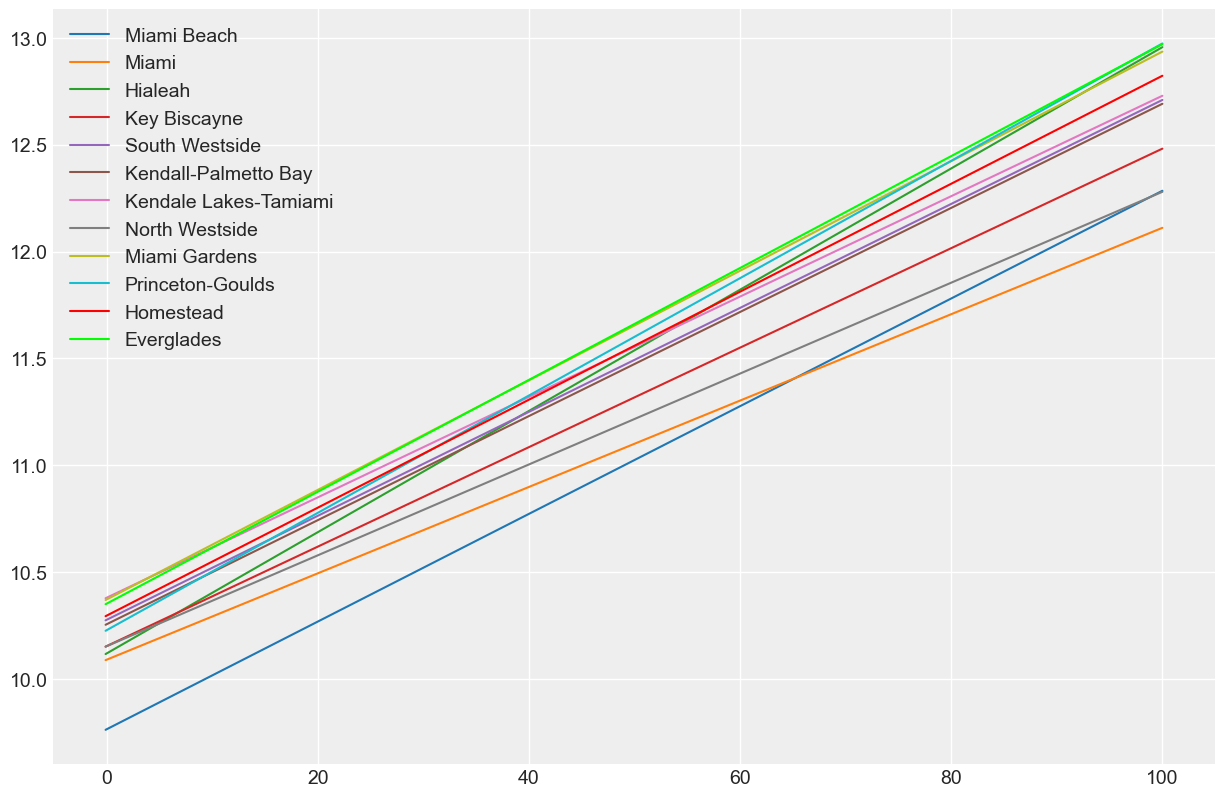

In [281]:
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
                                                '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'r', 'lime'])

fig, axes = plt.subplots(1, 1, figsize=(15, 10), sharey=True, sharex=True, constrained_layout=False)

for i,s in enumerate(subdivs):
    
    y = df.log_income[df['sub']==s]
    x = df.degree[df['sub']==s]
    xvals = np.linspace(-0.1, 100)
    intercept = deg_trace['a'].mean(axis=0)
    degree = deg_trace['o'].mean(axis=0)
    # axes.scatter(x, y, alpha=0.4, label=s)
    axes.plot(xvals, degree[sub_lookup[s]]*xvals + intercept[sub_lookup[s]], label=s)
    #axes.set_xlim(-2, 60)
    #axes.set_ylim(9.3, 10.75)
    axes.legend()